# Proyek Klasifikasi Gambar: Rice Image Dataset
- **Nama:** Nida'an Khafiyya
- **Email:** nidaankhafiyyaakun@gmail.com
- **ID Dicoding:** needkh

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
from PIL import Image
from collections import defaultdict

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"needkh","key":"380dd44c30f311ad772b3dcf3ec09341"}'}

In [4]:
# Download kaggle dataset and unzip the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip rice-image-dataset.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Kar

cek jumlah gambar dan resolusi dataset

In [5]:
# Menghitung jumlah gambar masing-masing kelas
def count_image_by_class(dataset_path):
  class_counts ={}
  for class_name in os.listdir(dataset_path):
    class_folder = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_folder):
      class_counts[class_name] = len(os.listdir(class_folder))

  print("\nJumlah gambar per kelas: ")
  for class_name, count in class_counts.items():
    print(f"- {class_name}: {count} gambar")

  return class_counts

# menghitung jumlah resolusi gambar masing-masing kelas
def count_image_by_resolution(dataset_path):
   resolution_counts = defaultdict(int)

   for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):
            for image_name in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_name)
                try:
                    with Image.open(image_path) as img:
                        resolution = img.size
                        resolution_counts[resolution] += 1
                except:
                    print(f" Gagal membaca {image_path}")

   print("\nJumlah gambar berdasarkan resolusi:")
   for resolution, count in resolution_counts.items():
        print(f"- {resolution}: {count} gambar")

   return resolution_counts

In [6]:
dataset_path = "Rice_Image_Dataset"

count_image_by_class(dataset_path)
count_image_by_resolution(dataset_path)


Jumlah gambar per kelas: 
- Karacadag: 15000 gambar
- Jasmine: 15000 gambar
- Basmati: 15000 gambar
- Ipsala: 15000 gambar
- Arborio: 15000 gambar

Jumlah gambar berdasarkan resolusi:
- (250, 250): 75000 gambar


defaultdict(int, {(250, 250): 75000})

Ubah resolusi gambar agar beragam

In [7]:
def resize_img(dataset_path, min_resolution=250, max_resolution=300):
  for root, dirs, folder in os.walk(dataset_path):
    for file in folder:
      file_path = os.path.join(root,file)

      if file.lower().endswith((".jpg")):
        with Image.open(file_path) as img:
          new_width = random.randint(min_resolution, max_resolution)
          new_height = random.randint(min_resolution, max_resolution)
          # mengubah ukuran
          resized_images = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

          # menyimpan perubahan resolusi gambar
          resized_images.save(file_path)

dataset_path = "/content/Rice_Image_Dataset"

resize_img(dataset_path)

In [8]:
dataset_path = "Rice_Image_Dataset"

count_image_by_class(dataset_path)
count_image_by_resolution(dataset_path)


Jumlah gambar per kelas: 
- Karacadag: 15000 gambar
- Jasmine: 15000 gambar
- Basmati: 15000 gambar
- Ipsala: 15000 gambar
- Arborio: 15000 gambar

Jumlah gambar berdasarkan resolusi:
- (285, 255): 25 gambar
- (273, 257): 25 gambar
- (266, 260): 29 gambar
- (266, 278): 32 gambar
- (272, 295): 30 gambar
- (255, 272): 38 gambar
- (275, 257): 33 gambar
- (282, 281): 28 gambar
- (300, 300): 47 gambar
- (288, 300): 24 gambar
- (282, 290): 29 gambar
- (257, 268): 29 gambar
- (252, 254): 34 gambar
- (275, 253): 25 gambar
- (291, 297): 34 gambar
- (296, 271): 25 gambar
- (274, 250): 32 gambar
- (271, 293): 31 gambar
- (286, 255): 22 gambar
- (291, 281): 34 gambar
- (260, 273): 21 gambar
- (287, 280): 28 gambar
- (286, 293): 31 gambar
- (276, 289): 23 gambar
- (256, 257): 31 gambar
- (298, 270): 20 gambar
- (265, 261): 29 gambar
- (267, 260): 29 gambar
- (300, 292): 30 gambar
- (293, 278): 28 gambar
- (253, 262): 36 gambar
- (288, 261): 33 gambar
- (278, 282): 33 gambar
- (300, 282): 33 gambar

defaultdict(int,
            {(285, 255): 25,
             (273, 257): 25,
             (266, 260): 29,
             (266, 278): 32,
             (272, 295): 30,
             (255, 272): 38,
             (275, 257): 33,
             (282, 281): 28,
             (300, 300): 47,
             (288, 300): 24,
             (282, 290): 29,
             (257, 268): 29,
             (252, 254): 34,
             (275, 253): 25,
             (291, 297): 34,
             (296, 271): 25,
             (274, 250): 32,
             (271, 293): 31,
             (286, 255): 22,
             (291, 281): 34,
             (260, 273): 21,
             (287, 280): 28,
             (286, 293): 31,
             (276, 289): 23,
             (256, 257): 31,
             (298, 270): 20,
             (265, 261): 29,
             (267, 260): 29,
             (300, 292): 30,
             (293, 278): 28,
             (253, 262): 36,
             (288, 261): 33,
             (278, 282): 33,
             (300, 282): 3

In [9]:
# Direktori awal
initial_dir = "Rice_Image_Dataset"

# Direktori baru untuk dataset gabungan
combined_dir = "rice/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari direktori awal
for category in os.listdir(initial_dir):
    category_dir = os.path.join(initial_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

Plot gambar sampel untuk semua kelas

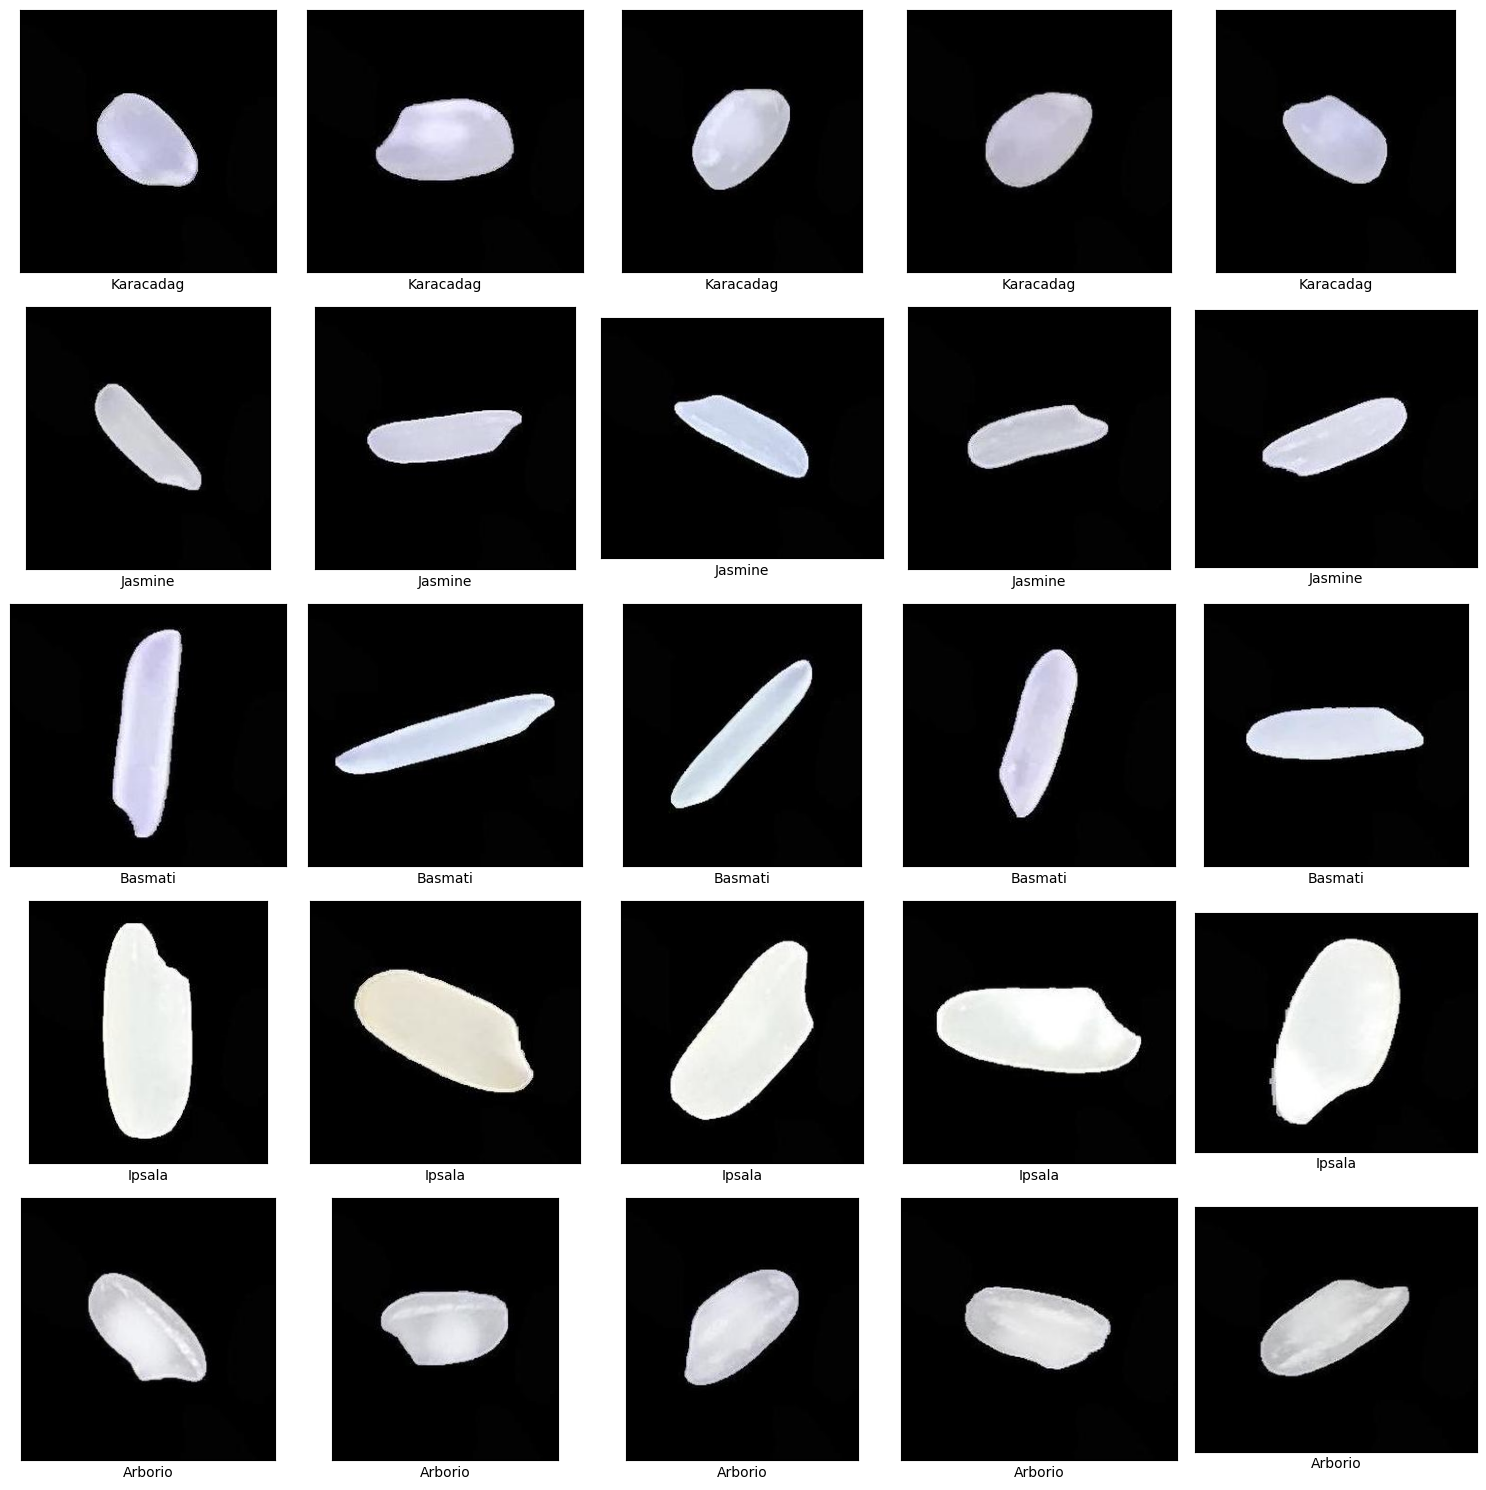

In [10]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
rice_image = {}

# Tentukan path sumber train
path = "rice/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    rice_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(rice_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(rice_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()
plt.show()

Plot distribusi gambar di seluruh kelas

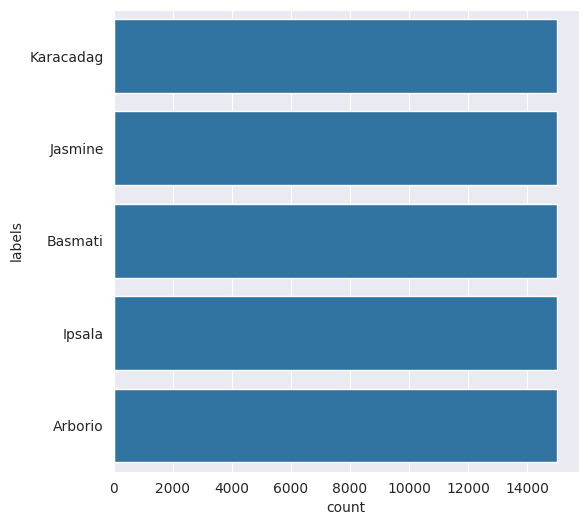

In [11]:
# Define source path
rice_path = "rice/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(rice_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [12]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'rice/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Arborio,15000
Basmati,15000
Ipsala,15000
Jasmine,15000
Karacadag,15000


Bagi dataset menjadi 70% train, 15% validation, dan 15% test

In [13]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split 15% test dari seluruh data
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=300)

# Split 17.6% validation dari 85% data yang tersisa (≈ 15% dari total)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=300)

In [14]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_val = pd.DataFrame({'path':X_val,'labels':y_val,'set':'validation'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [15]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('validation size', len(df_val))
print('test size', len(df_te))

train size 52530
validation size 11220
test size 11250


In [16]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set         labels   
test        Arborio       2231
            Basmati       2252
            Ipsala        2241
            Jasmine       2215
            Karacadag     2311
train       Arborio      10449
            Basmati      10509
            Ipsala       10596
            Jasmine      10517
            Karacadag    10459
validation  Arborio       2320
            Basmati       2239
            Ipsala        2163
            Jasmine       2268
            Karacadag     2230
dtype: int64 


                                               path     labels         set
68983         rice/dataset/Ipsala/Ipsala (3733).jpg     Ipsala  validation
11193      rice/dataset/Arborio/Arborio (14993).jpg    Arborio       train
72426  rice/dataset/Karacadag/Karacadag (13098).jpg  Karacadag  validation
19517       rice/dataset/Basmati/basmati (6420).jpg    Basmati       train
35986   rice/dataset/Karacadag/Karacadag (7798).jpg  Karacadag       train


In [17]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "rice/dataset/"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

In [18]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

 Image Data Generator


In [19]:
# Define training and test directories
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"
VAL_DIR = "Dataset-Final/validation/"

# Daftar label
labels = [
    'Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'
]

# Cetak jumlah gambar di setiap set
for label in labels:
    train_path = os.path.join(TRAIN_DIR, label)
    test_path = os.path.join(TEST_DIR, label)
    val_path = os.path.join(VAL_DIR, label)

    print(f"Train - {label}: {len(os.listdir(train_path))}")
    print(f"Test  - {label}: {len(os.listdir(test_path))}")
    print(f"Val   - {label}: {len(os.listdir(val_path))}")

Train - Arborio: 10449
Test  - Arborio: 2231
Val   - Arborio: 2320
Train - Basmati: 10509
Test  - Basmati: 2252
Val   - Basmati: 2239
Train - Ipsala: 10596
Test  - Ipsala: 2241
Val   - Ipsala: 2163
Train - Jasmine: 10517
Test  - Jasmine: 2215
Val   - Jasmine: 2268
Train - Karacadag: 10459
Test  - Karacadag: 2311
Val   - Karacadag: 2230


In [20]:
# Create an ImageDataGenerator object normalizing the images
datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = val_datagen.flow_from_directory(VAL_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 52530 images belonging to 5 classes.
Found 11220 images belonging to 5 classes.
Found 11250 images belonging to 5 classes.


## Modelling


In [21]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D((2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model.add(Conv2D(16, (3, 3),padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())
# 1nd Dense Layer
model.add(Dense(32, activation = 'relu'))
# 1nd Dropout Layer
model.add(Dropout(0.3))
# 2nd Dense Layer
model.add(Dense(5, activation = 'softmax'))
######################### Fully Connected Layer ################################

######################### Compile Model ################################
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       700,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 703,893 (2.69 MB)

 Trainable params: 703,893 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
# Daftar label (pastikan urutannya sama dengan urutan class_indices di generator)
labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# Ambil class indices dari train_generator
class_indices = train_generator.class_indices  # misalnya: {'daisy': 0, 'dandelion': 1, ...}

# Ambil label dari data generator (integer label)
y_train = train_generator.classes

# Hitung class weights
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# Konversi ke dictionary
class_weights = dict(enumerate(class_weights_array))

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.98):
      print("\nAccuracy has been achieved >98%")
      self.model.stop_training = True

callbacks = myCallback()

%time

# Fitting / training model
history = model.fit(train_generator,
                        epochs=16,
                        validation_data=validation_generator,
                        verbose=1,
                        class_weight = class_weights,
                        callbacks=[callbacks])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.72 µs
Epoch 1/16


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1642/1642 ━━━━━━━━━━━━━━━━━━━━ 88s 51ms/step - accuracy: 0.8726 - loss: 0.3359 - val_accuracy: 0.9694 - val_loss: 0.0927
Epoch 2/16
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 65s 39ms/step - accuracy: 0.9489 - loss: 0.1404 - val_accuracy: 0.9699 - val_loss: 0.0813
Epoch 3/16
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 82s 39ms/step - accuracy: 0.9669 - loss: 0.0940 - val_accuracy: 0.9865 - val_loss: 0.0450
Epoch 4/16
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step - accuracy: 0.9753 - loss: 0.0708 - val_accuracy: 0.9866 - val_loss: 0.0425
Epoch 5/16
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9778 - loss: 0.0662
Accuracy has been achieved >98%
1642/1642 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step - accuracy: 0.9778 - loss: 0.0662 - val_accuracy: 0.9884 - val_loss: 0.0392


## Evaluasi dan Visualisasi

In [24]:
# Cek akurasi
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

print(f"Training Accuracy: {train_acc:.2%}")
print(f"Validation Accuracy: {val_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11250/11250 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9848 - loss: 0.0523
Training Accuracy: 98.01%
Validation Accuracy: 98.84%
Test Accuracy: 98.84%


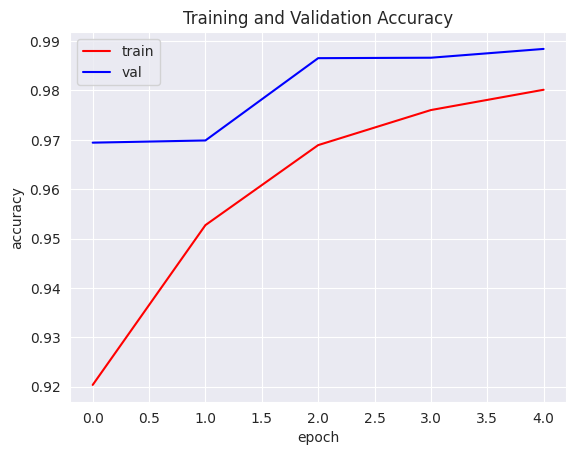

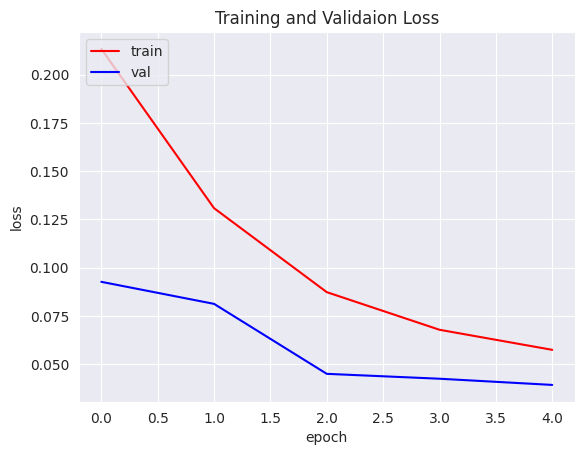

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

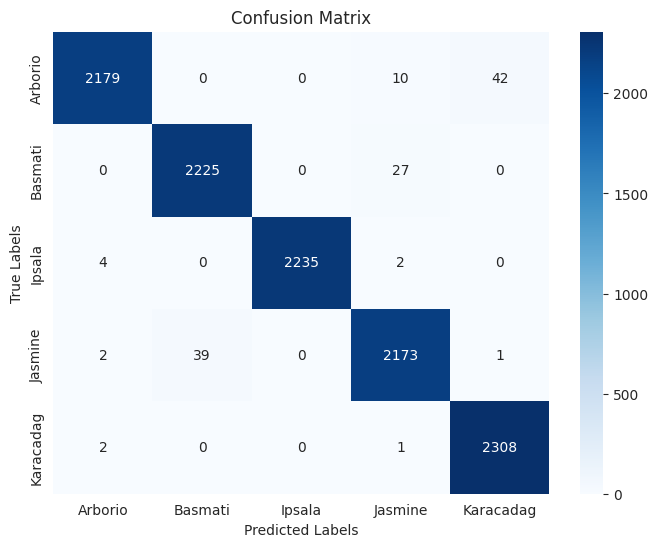


Classification Report:

              precision    recall  f1-score   support

     Arborio     0.9963    0.9767    0.9864      2231
     Basmati     0.9828    0.9880    0.9854      2252
      Ipsala     1.0000    0.9973    0.9987      2241
     Jasmine     0.9819    0.9810    0.9815      2215
   Karacadag     0.9817    0.9987    0.9901      2311

    accuracy                         0.9884     11250
   macro avg     0.9886    0.9884    0.9884     11250
weighted avg     0.9885    0.9884    0.9884     11250



In [27]:
# Reset generator
test_generator.reset()

# Prediksi (probabilitas softmax)
preds = model.predict(test_generator, verbose=0)

# Ambil label prediksi (kelas dengan probabilitas tertinggi)
pred_classes = np.argmax(preds, axis=1)

# Ambil label sebenarnya dari test generator
true_classes = test_generator.classes

# Ambil label string dari kelas (misalnya: ['Arborio', 'Basmati', ...])
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_classes, pred_classes)

# Visualisasi Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(pd.DataFrame(cm, index=class_labels, columns=class_labels), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels, digits=4))


## Konversi Model

In [33]:
# Save the model as a .h5 file
model.save('rice_model.h5')

# Convert and save the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('rice_model.tflite', 'wb') as f:
  f.write(tflite_model)

# Save class labels to a text file for TensorFlow Lite
# Define the actual class labels
class_labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

with open('labels.txt', 'w') as f:
  for label in class_labels:  # Iterate over the class labels
      f.write(label + '\n')

# Convert and save the model to TensorFlow.js format
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, 'rice_model_tfjs')

# Save the model as a .pb file (SavedModel format)
model.export('rice_model_pb')

Saved artifact at '/tmp/tmpyrg60oqq'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136492388818320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492388816592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492388817168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492388818704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492402142352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492402141968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492402140048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492282401360: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file
Saved artifact at 'rice_model_pb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  136492388818320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492388816592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492388817168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492388818704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492402142352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492402141968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492402140048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136492282401360: TensorSpec(shape=(), dtype=tf.resource, name=None)


## Inference (Optional)

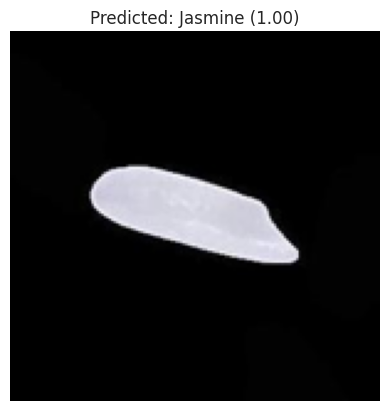

In [35]:
# === Muat model TFLite ===
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# Ambil informasi tensor input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# === Ambil satu gambar contoh untuk inferensi ===
img_path = 'rice/dataset/Jasmine/Jasmine (10).jpg'
img = Image.open(img_path).resize((150, 150))  # Resize sesuai input model
img_array = np.array(img) / 255.0  # Normalisasi
if len(img_array.shape) == 2:  # Jika grayscale, ubah ke 3 channel
    img_array = np.stack((img_array,) * 3, axis=-1)

input_data = np.expand_dims(img_array, axis=0).astype(np.float32)

# === Inference ===
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)
confidence = np.max(output_data)

# Label kelas (sesuai urutan training)
labels = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

# === Tampilkan hasil ===
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {labels[predicted_class]} ({confidence:.2f})")
plt.show()